# Load data

In [74]:
import os
import pandas as pd

annotations_dir = "comparison-3"
annotations_dir = "commit-annotator"
reviews_dir = "comparison-3"

annot_cols = ['bfc', 'bpc', 'prc', 'nfc']

def get_cols(results_df, cols):
    """Get columnos from dataframe (in addition to 'hash', which is always got)"""
    
    df = results_df[['hash'] + cols]
    return df

def read_csv_from_dir(dirname, filename, cols):
    cols_converters = {col: int for col in cols}
    results = pd.read_csv(os.path.join('..', dirname, filename),
                          converters=cols_converters)
    return results
    
results_A = read_csv_from_dir(annotations_dir, 'annotations_Michel.csv', annot_cols)
results_B = read_csv_from_dir(annotations_dir, 'annotations_Abhishek.csv', annot_cols)
results_C = read_csv_from_dir(annotations_dir, 'annotations_David.csv', annot_cols)

data_A = get_cols(results_A, annot_cols)
data_B = get_cols(results_B, annot_cols)
data_C = get_cols(results_C, annot_cols)

data_df = pd.merge(data_A, data_B, on='hash', how='inner', suffixes=('A', 'B'))
data_df = pd.merge(data_df, data_C, on='hash', how='inner', suffixes=('', 'C'))

def rename_cols (cols, suffix):
    return {col: col + suffix for col in cols}

data_df = data_df.rename(columns=rename_cols(annot_cols, 'C'))
                         
results_R = read_csv_from_dir(reviews_dir, 'review_jesus.csv', annot_cols)
data_R = get_cols(results_R, annot_cols)
data_df = pd.merge(data_df, data_R, on='hash', how='left')
data_df = data_df.rename(columns=rename_cols(annot_cols, 'R'))

#BFCs['bfcR'] = BFCs['bfc']
#BFCs = BFCs[['hash', 'bfcA', 'bfcB', 'bfcC', 'bfcR']]
data_df

,hash,bfcA,bpcA,prcA,nfcA,bfcB,bpcB,prcB,nfcB,bfcC,bpcC,prcC,nfcC,bfcR,bpcR,prcR,nfcR
0,0704a8586f,0,0,4,0,0,3,4,0,0,0,4,0,0.0,0.0,3.0,0.0
1,c5e97ed154,0,0,4,0,0,4,4,0,0,0,4,0,0.0,0.0,4.0,0.0
2,4f9f531e15,0,1,4,0,0,4,4,0,0,1,4,0,0.0,0.0,4.0,0.0
3,258030acc9,0,0,4,0,0,4,4,0,0,0,4,0,0.0,0.0,4.0,0.0
4,5b2c5540b8,4,1,0,0,4,0,0,0,3,2,0,0,4.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,b02ba9ed7c,0,0,4,0,0,0,4,0,0,0,4,0,NaN,NaN,NaN,NaN
907,868695e43b,0,0,0,4,0,0,0,4,0,0,0,4,NaN,NaN,NaN,NaN
908,7afc1f6977,0,0,0,4,0,0,0,4,0,0,0,4,NaN,NaN,NaN,NaN
909,ac686cbc6f,0,0,3,4,0,0,0,4,0,0,3,4,NaN,NaN,NaN,NaN


# Compute estimations

In [56]:
import math

def estimation(A, B, C, R):
    if math.isnan(R):
        return round((A + B + C) / 3)
    else:
        return int(R)

def estimation_col(df, cols):
    """Estimation for a column, for example, bfc"""
    for col in cols:
        data_df[col] = data_df.apply(lambda row: estimation(row[col+'A'], row[col+'B'], row[col+'C'], row[col+'R']),
                                     axis=1)
    return data_df

data_df = estimation_col(data_df, annot_cols)

# Produce an estimation based on the higher from bfc, bpc, prc, nfc:
data_df['kind'] = data_df[annot_cols].apply(lambda row: row.idxmax(), axis=1)

kind_counts = data_df['kind'].value_counts()
kind_fractions = data_df['kind'].value_counts(normalize=True)
print(kind_counts, kind_fractions)

kind
prc    446
bfc    204
nfc    145
bpc    116
Name: count, dtype: int64 kind
prc    0.489572
bfc    0.223930
nfc    0.159166
bpc    0.127333
Name: proportion, dtype: float64


pandas.core.series.Series

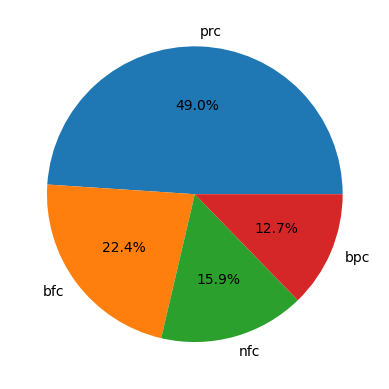

In [70]:
import matplotlib.pyplot as plt

plt.pie(kind_counts, labels=kind_counts.index, autopct='%1.1f%%')
plt.savefig(os.path.join("figs", f"kind_counts.eps"))
#plt.show()

# In the context of all commits in our dataset

In [46]:
total_commits = 1233421
annotated_commits = len(data_df)
print(f"Total commits in sample: {total_commits}, annotated commits: {annotated_commits}")

Total commits in sample: 1233421, annotated commits: 911


In [69]:
import tabulate
import os

kind_counts_total = kind_fractions.mul(total_commits)
for kind, kind_count in kind_counts_total.items():
    print(f"{kind}: {kind_count:1.0f}")

with open(os.path.join('tables','kind_counts_total.tex'), 'w') as f:
    latex_table = tabulate.tabulate(kind_counts_total.to_frame(), tablefmt="latex")
    print(latex_table, file=f)

prc: 603848
bfc: 276200
nfc: 196318
bpc: 157055
